In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

import h5py

import hdf5_getters
from hdf5_getters import *

In [3]:
def count_all_files(basedir,ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [4]:
def get_all(getter, base_directory, ext='.h5'):
    values = []
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            values.append( getter(h5) )
            h5.close()
    return values

In [7]:
def get_file_fields(file, all_getters):
    fields = []
    for getter_name in all_getters:
        getter = getattr(hdf5_getters, getter_name)
        fields.append(getter(h5))
    return fields

In [5]:
base_directory = './millionsongsubset_full/MillionSongSubset/data'

In [8]:
print('Number of songs:', count_all_files(base_directory))

Number of songs: 10000


In [10]:
all_getters = list(filter(lambda x: x[:3] == 'get',hdf5_getters.__dict__.keys()))
print('Number of getters:', len(all_getters))

Number of getters: 55


#### Building the dataframe (only subset)

In [ ]:
#iterate over all the .h5 files, starting from the base directory
#note: takes between ~8 to ~10 minutes
start_time = time.time()

values = []
ext = '.h5'

for root, dirs, files in os.walk(base_directory):
    files = glob.glob(os.path.join(root,'*'+ext))
    for f in files:
        h5 = hdf5_getters.open_h5_file_read(f)
        values.append(get_file_fields(h5, all_getters))
        h5.close()        

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

In [ ]:
#create the column names from the getter names
column_names = []
for getter_name in all_getters:
    column_names.append(getter_name[4:].replace('_', ' '))

In [ ]:
#create a dataframe with the given column names
data = pd.DataFrame(columns=column_names)
data.head()

In [ ]:
#fill the dataframe row by row
nb_entries = len(values)
for i in range(0, nb_entries):
    data.loc[i] = values[i]

In [ ]:
data.head()

In [ ]:
#write the dataframe to a .csv file
#note: takes several minutes
start_time = time.time()
data.to_csv('msd_data.csv', sep='\t', encoding='utf-8')
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

#### Retrieving the dataframe

In [23]:
data = pd.read_csv('msd_data_save.csv', sep='\t', index_col=0)
data.head()

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,[ 1. 1. 0.218 0.133 0.384 0.326 0....,[ 0.58521 1.19196 1.78893 2.37813 ...,[ 0.834 0.851 0.65 0.635 0.532 0.753 0....,[ 0.58521 2.94247 5.14371 7.74554 ...,[ 0.643 0.746 0.722 0.095 0.091 0.362 0....,[ 0.28519 0.58521 0.89422 1.19196 ...,[ 0.779 0.734 0.674 0.637 0.597 0.532 0....,[],[],0
1,1,0.630630,0.417500,b'ARMJAGH1187FB546F3',b'1c78ab62-db33-4433-8d0b-7c8dcf1849c2',22066,1998,35.14968,-90.04892,"b'Memphis, TN'",...,[ 1. 0.451 0.27 0.397 0.225 0.426 0....,[ 0.20627 0.71054 1.21836 1.71841 ...,[ 1. 0.945 0.714 0.973 0.818 0.974 0....,[ 0.71054 2.71502 4.70861 6.69288 ...,[ 0.007 0.259 0.172 0.404 0.011 0.016 0....,[ 0.20627 0.45904 0.71054 0.96834 ...,[ 0.969 0.929 0.897 0.871 0.856 0.845 0....,[b'classic pop and rock'],[1],1969
2,1,0.487357,0.343428,b'ARKRRTF1187B9984DA',b'7a273984-edd9-4451-9c4d-39b38f05ebcd',13951,290021,NaN,NaN,b'',...,[ 1. 0.121 0.214 0.198 0.66 0.468 0....,[ 0.73152 1.39732 2.04852 2.68691 ...,[ 0.98 0.399 0.185 0.27 0.422 0. 0....,[ 0.73152 1.39732 2.04852 2.68691 ...,[ 0.98 0.399 0.185 0.27 0.422 0. 0....,[ 0.42132 0.73152 1.06609 1.39732 ...,[ 0.482 0.676 0.627 0.549 0.279 0.264 0....,[],[],0
3,1,0.630382,0.454231,b'AR7G5I41187FB4CE6C',b'e188a520-9cb7-4f73-a3d7-2f70c6538e92',12697,19072,NaN,NaN,"b'London, England'",...,[ 1. 0.086 0.153 0.146 0.088 0.217 0....,[ 0.81002 1.30621 1.80617 2.2996 ...,[ 0.809 0.616 0.789 0.66 0.439 0.758 0....,[ 1.30621 3.29887 5.30252 7.32327 ...,[ 0.017 0.05 0.014 0.008 0.114 0.019 0....,[ 0.56254 0.81002 1.05749 1.30621 ...,[ 0.601 0.556 0.523 0.49 0.466 0.44 0....,[b'uk' b'british' b'english'],[1 1 1],1982
4,1,0.651046,0.401724,b'ARXR32B1187FB57099',b'c6903a2e-063c-4f91-a284-17b8f421be7b',8355,30973,NaN,NaN,b'',...,[ 1. 0.768 0.611 0.388 0.52 0.42 0....,[ 1.35760000e-01 5.99140000e-01 1.0636800...,[ 0.883 0.738 0.484 0.609 0.625 0.719 0....,[ 1.06368 2.91491 4.76729 6.61852 ...,[ 0.175 0.409 0.639 0.067 0.016 0.066 0....,[ 1.35760000e-01 3.69180000e-01 5.9914000...,[ 1. 0.98 0.932 0.87 0.82 0.793 0....,[],[],2007


#### Basic statistics

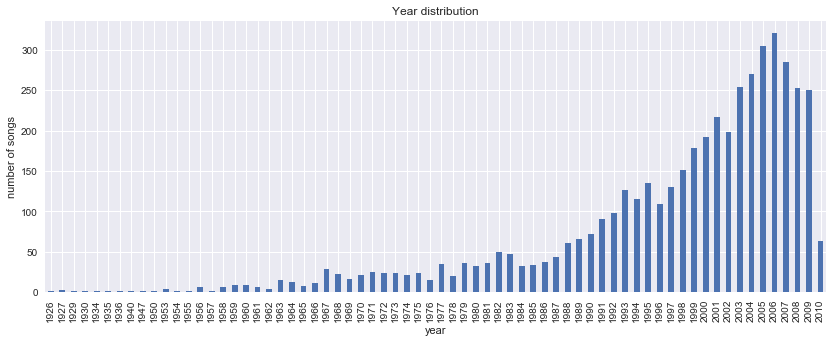

In [29]:
ax = data[data['year'] > 0]['year'].value_counts().sort_index().plot(kind='bar',
                                                                      grid=True,
                                                                      figsize=(14, 5),
                                                                      title='Year distribution');

ax.set_xlabel('year')
ax.set_ylabel('number of songs');